# SPARTA

We have SARS-CoV-2 spike-binding measurements available on 10,000 samples from 500 participants.
We want to:
- Look at what we have
- Pick the top 30 or so and the bottom 30 or so participants, by "antibody response strength"
- Clean up and deidentify metadata for those participants
- Send out for additional testing

In addition to those measurements, we know that participants have different demographics, SARS-CoV-2 infection and vaccination timing, vaccine types, and sampling frequency (we tried to get them monthly, but sometimes that's just how it goes)

## Imports

In [1]:
import pandas as pd # Excel+, tables and more
import numpy as np # Maths
import matplotlib.pyplot as plt # Setting up figures, axis labels, etc
import seaborn as sns # Scatterplots and stripplots and histograms, oh my
from scipy import stats # T tests, mann whitney u, ordinary least squares linear regression
import sys # for difficulties installing packages
!{sys.executable} -m pip install statsmodels
import statsmodels.api as sm # robust lineear regression
import statsmodels.formula.api as smf # mixed effect models
import sklearn # multilayer perceptrons, support vector machines, random forests


## Python Reference

In [4]:
# Comments
# Any line starting with a hash is a comment
# In addition to markdown cells (or in a script), you can annotate your code in-line with comments to describe what it does
# In order to change a line to and from a comment, you can use the shortcut Ctrl+/ (or Cmd+/ on Mac)

# Uncomment the bottom line (click on the line to place your cursor in and hit Ctrl+/)
# and run the cell (press the play button in the upper left corner, or Shift+Enter with your cursor in the cell) to generate a random plot

# plt.plot(np.random.randn(100))

In [6]:
# Seaborn maintains a few datasets useful for example plots. 
# You can look at the first 5 rows of your dataset with the head() function.
# Run this cell to see what's in the penguins dataset. (shift+enter to run)
penguin_data = sns.load_dataset('penguins')
penguin_data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [8]:
# You can look at a couple default summary statistics of the dataset with the describe() function.
penguin_data.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


Notice that it dropped all the non-numeric columns, and gives you these count statistics. You can also use `describe()` for non-numeric data, but it is not quite as useful.

Still, it does take us to our next operation: grabbing just one column from the table. In pandas, usually a table is called a "DataFrame" and a row or column is called a "Series". If we want to look at just one column, we use square braces [] and single or double quotes containing the column name. To look at just species information, we would call `penguin_data['species']` instead of `penguin_data`. Let's look at the description for just that Series

In [9]:
penguin_data['species'].describe()

count        344
unique         3
top       Adelie
freq         152
Name: species, dtype: object

Not bad, but not great. You know that there are 3 values, but not what they are. This could be good if you had thousands of different species, but with just 3 we might want more details about each one. There's a function on Series called `value_counts()` which works well here.

In [10]:
# Calling `display()` lets you show the output of multiple rows in a single notebook cell.
display(penguin_data['species'].value_counts())
display(penguin_data['island'].value_counts())

species
Adelie       152
Gentoo       124
Chinstrap     68
Name: count, dtype: int64

island
Biscoe       168
Dream        124
Torgersen     52
Name: count, dtype: int64

Now we have some counts and some basic statistics. We can do a little better and break these penguin features down by both species and island with the `groupby` command.

In [11]:
display(penguin_data.groupby(['species', 'island']).size())

species    island   
Adelie     Biscoe        44
           Dream         56
           Torgersen     52
Chinstrap  Dream         68
Gentoo     Biscoe       124
dtype: int64

Looks like only the Adelie are travelers. Let's forget about islands, then, and look at flippers and beaks

In [14]:
display(penguin_data.drop(columns=['island', 'sex']).groupby(['species']).mean()) # You can't take tghe mean of a string, so we drop the non-numeric columns. Equivalent to:
display(penguin_data.loc[:, ['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].groupby(['species']).mean())

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.504878,14.982114,217.186992,5076.016260


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
species,,,,
Adelie,38.791391,18.346358,189.953642,3700.662252
Chinstrap,48.833824,18.420588,195.823529,3733.088235
Gentoo,47.504878,14.982114,217.186992,5076.016260


Couple of new operations there:
- `data.drop(columns=['col1', 'col2'])` gives you a copy of your dataframe (table) without col1 and col2
- `data.loc[:, 'col1']` is the same as `data['col1']`, it just grabs that column. Here `:` stands for "every row", so it extends to:
- `data.loc[:, ['col1', 'col2']]` to get the two columns you want. `loc[]` uses column and row names. If I wanted the first two columns, I could use `iloc`
- `data.iloc[:5, :2]` is the first two columns for the first 5 rows
- `data.iloc[-5:, -2:]` is the last two columns for the last 5 rows

`iloc` uses numbers and does not know about names at all. See below for an example. 

In [15]:
penguin_data.iloc[:5, :2]

,species,island
0,Adelie,Torgersen
1,Adelie,Torgersen
2,Adelie,Torgersen
3,Adelie,Torgersen
4,Adelie,Torgersen


You can also filter quite easily any which way with indexes.

In [17]:
display(penguin_data[penguin_data['species'] == 'Chinstrap'].head()) # chinstrap penguins
species_filter = penguin_data['species'] == 'Adelie'
sex_filter = penguin_data['sex'] == 'Male'
display(penguin_data[species_filter & sex_filter].head()) # male Adelie penguins
size_filter = penguin_data['body_mass_g'] < 3800.
display(penguin_data[species_filter & sex_filter & size_filter].head()) # tiny male Adelie penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
152,Chinstrap,Dream,46.5,17.9,192.0,3500.0,Female
153,Chinstrap,Dream,50.0,19.5,196.0,3900.0,Male
154,Chinstrap,Dream,51.3,19.2,193.0,3650.0,Male
155,Chinstrap,Dream,45.4,18.7,188.0,3525.0,Female
156,Chinstrap,Dream,52.7,19.8,197.0,3725.0,Male


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
13,Adelie,Torgersen,38.6,21.2,191.0,3800.0,Male
14,Adelie,Torgersen,34.6,21.1,198.0,4400.0,Male


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
21,Adelie,Biscoe,37.7,18.7,180.0,3600.0,Male
26,Adelie,Biscoe,40.6,18.6,183.0,3550.0,Male
46,Adelie,Dream,41.1,19.0,182.0,3425.0,Male


`==` checks equality. You can compose filters with `&` when you want both to be true, and `|` when only one needs to be true. You can compare Series to individual values, or to each other

In [20]:
display(penguin_data[penguin_data['bill_depth_mm'] * 2 < penguin_data['bill_length_mm']].head()) # bill depth is less than half the bill length
penguin_data[penguin_data['bill_depth_mm'] * 2 > penguin_data['bill_length_mm']].head() # bill depth is greater than half the bill length

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN
13,Adelie,Torgersen,38.6,21.2,191.0,3800.0,Male
14,Adelie,Torgersen,34.6,21.1,198.0,4400.0,Male


Finally, plots! `sns.relplot` (scatter and line) and `sns.catplot` (strip and box) will help you out here

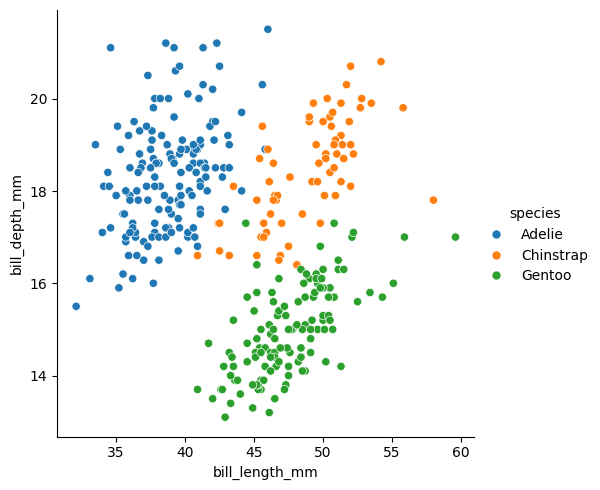

In [21]:
sns.relplot(data=penguin_data, x='bill_length_mm', y='bill_depth_mm', hue='species')
plt.show()

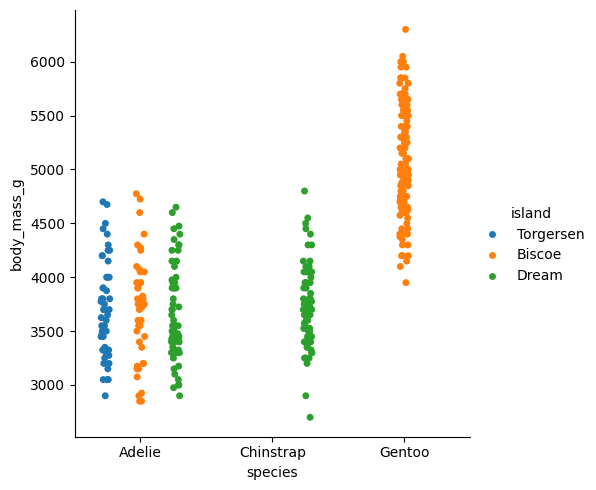

In [22]:
sns.catplot(data=penguin_data, x='species', y='body_mass_g', hue='island', dodge=True, kind='strip')
plt.show()

## Reading in the data and taking a look

We have participant metadata and sample testing results in the `data` directory. Poke around! Make some plots!

In [28]:
people_data = pd.read_csv('../data/Participant Metadata.csv').set_index('Participant ID') # Reads in a csv from the data directory
display(people_data.head())
sample_data = pd.read_csv('../data/Sample Data.csv').set_index('Sample ID') # Uncomment this line and add the code to load the participant data
display(sample_data.head()) 
data = sample_data.join(people_data, on='Participant ID') # Adds the participant data to the sample data. Works as is, uncomment with Ctrl+/ to run
display(data.head()) # Displays the first 5 rows of the participant data

,Name,Email,Sex,Race,Infection Pre-Vaccine,Age,Vaccine Type,Dose 1 Date,Dose 2 Date,Infection 1 Date,Infection 2 Date,Dose 3 Date,Baseline Date
Participant ID,,,,,,,,,,,,,
SPARTA-001,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21
SPARTA-002,Keelan Garrison,keelan.garrison@gch.org,Male,Asian,Yes,46,Pfizer,2021-02-04,2021-02-25,2020-05-04,2022-02-25,2021-12-20,2020-06-01
SPARTA-003,Harry Boyer,harry.boyer@gch.org,Male,White,Yes,43,Pfizer,2021-01-30,2021-02-19,2020-04-13,NaN,2021-10-15,2020-06-09
SPARTA-004,Meghan Roman,meghan.roman@gch.org,Female,White,No,47,Pfizer,2021-01-13,2021-02-03,2022-01-30,NaN,2021-09-21,2021-01-06
SPARTA-005,Jerry Sloan,jerry.sloan@gch.org,Female,White,No,36,Moderna,2021-01-11,2021-02-09,2022-01-06,NaN,2021-09-18,2020-06-12


,Participant ID,Date,AUC
Sample ID,,,
W3310,SPARTA-001,2020-12-21,5.000000
C6935,SPARTA-001,2021-03-15,778.513374
X2393,SPARTA-001,2021-05-11,262.368202
G4311,SPARTA-001,2021-06-07,177.732519
G9478,SPARTA-001,2021-07-30,183.948574


,Participant ID,Date,AUC,Name,Email,Sex,Race,Infection Pre-Vaccine,Age,Vaccine Type,Dose 1 Date,Dose 2 Date,Infection 1 Date,Infection 2 Date,Dose 3 Date,Baseline Date
Sample ID,,,,,,,,,,,,,,,,
W3310,SPARTA-001,2020-12-21,5.000000,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21
C6935,SPARTA-001,2021-03-15,778.513374,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21
X2393,SPARTA-001,2021-05-11,262.368202,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21
G4311,SPARTA-001,2021-06-07,177.732519,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21
G9478,SPARTA-001,2021-07-30,183.948574,Hajra Odom,hajra.odom@gch.org,Female,Asian,No,42,Pfizer,2021-01-15,2021-02-07,2022-02-03,NaN,2021-10-04,2020-12-21


In [43]:
people_data['Name'].str.lower().str.replace("'", "").str.replace('([a-z])[a-z]* ([a-z]{5})[a-z]*', '\\2\\1 01', regex=True).str.replace('([a-z]{2})[a-z]* ([a-z]{4})[a-z]*', '\\2\\1 01', regex=True).str.replace(' ', '') # Converts the names to lowercase

Participant ID
SPARTA-001    odomha01
SPARTA-002    garrik01
SPARTA-003    boyerh01
SPARTA-004    romanm01
SPARTA-005    sloanj01
                ...   
SPARTA-496    walljo01
SPARTA-497    randae01
SPARTA-498    grahat01
SPARTA-499    connoc01
SPARTA-500    princl01
Name: Name, Length: 500, dtype: object

In [44]:
people_data.describe()

,Age
count,500.000000
mean,44.962000
std,6.661028
min,32.000000
25%,40.000000
50%,44.000000
75%,49.000000
max,70.000000


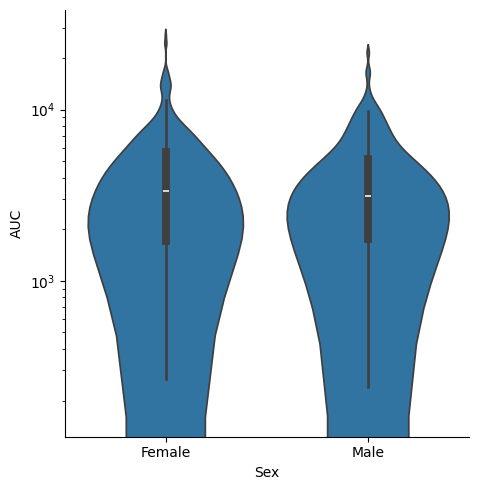

In [51]:
sns.catplot(data=data.drop_duplicates(subset=['Participant ID'], keep='last'), x='Sex', y='AUC', kind='violin')
plt.yscale('log')

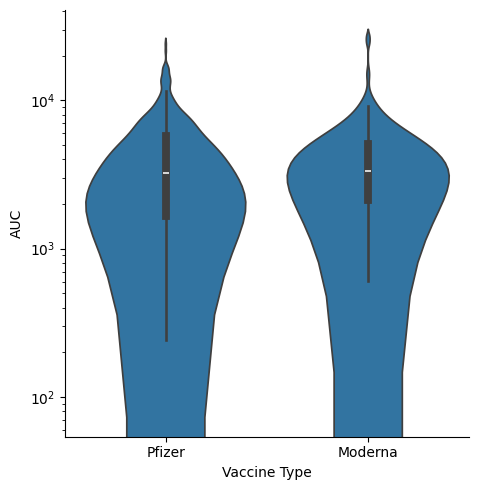

In [52]:
sns.catplot(data=data.drop_duplicates(subset=['Participant ID'], keep='last'), x='Vaccine Type', y='AUC', kind='violin')
plt.yscale('log')

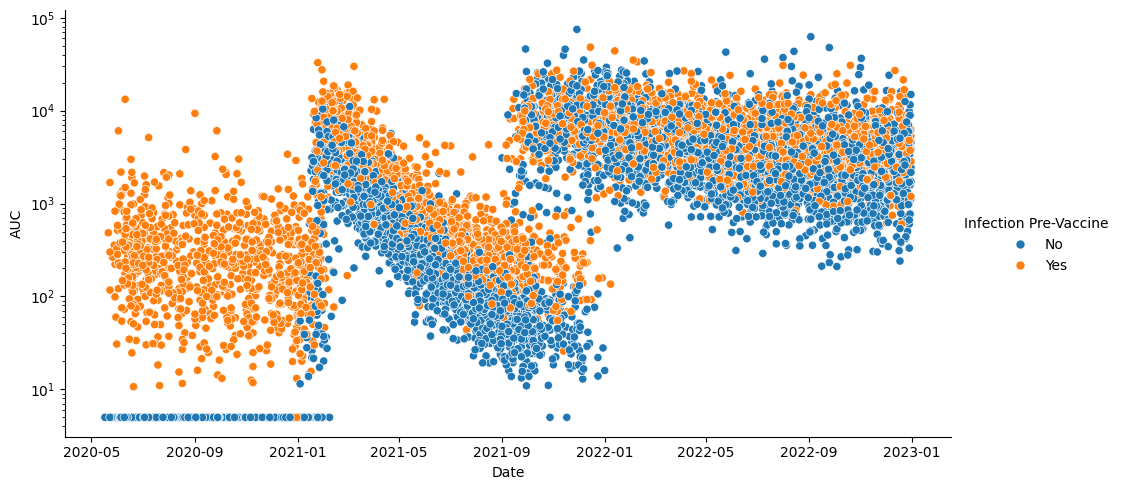

In [56]:
data['Date'] = pd.to_datetime(data['Date']) # Convert the Date column to datetime format
sns.relplot(data=data, x='Date', y='AUC', hue='Infection Pre-Vaccine', aspect=2)
plt.yscale('log')
plt.show()

In [66]:
pd.to_datetime(data['Dose 3 Date']) - pd.to_datetime(data['Dose 2 Date'])

Sample ID
W3310   239 days
C6935   239 days
X2393   239 days
G4311   239 days
G9478   239 days
          ...   
H8922   307 days
O4799   307 days
I4917   307 days
A2888   307 days
R2796   307 days
Length: 9595, dtype: timedelta64[ns]

In [67]:
data['Time Between Dose 3 and Dose 2'] = (pd.to_datetime(data['Dose 3 Date']) - pd.to_datetime(data['Dose 2 Date'])).dt.days

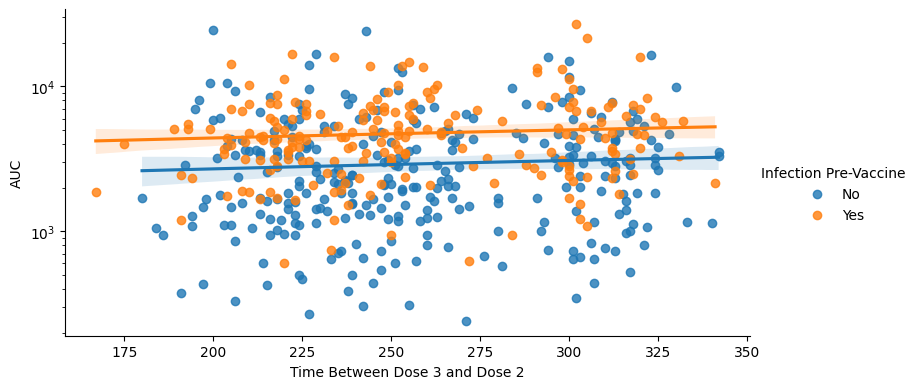

In [71]:
sns.lmplot(data=data.drop_duplicates(subset=['Participant ID'], keep='last'), x='Time Between Dose 3 and Dose 2', y='AUC', height=4, aspect=2, hue='Infection Pre-Vaccine', robust=True)
plt.yscale('log')


## Picking overperformers and underperformers

Now that you've taken a look, it's onto the next task

### High and low performers
We want to run additional testing on a subset of participants (10 or 20%). How would you pick a subset of participants to run?
- You can answer this with a markdown cell at first if you're not ready to code it.
- How would you do it if you were totally confident in Python?
- What's one quick way that you would be comfortable doing now?

In [73]:
people_data['Last Date'] = data.groupby('Participant ID')['Date'].max() # Gets the last date for each participant
people_data['Days on Study'] = (people_data['Last Date'] - pd.to_datetime(people_data['Baseline Date'])).dt.days # Calculates the number of days on study

<Axes: xlabel='y', ylabel='Days on Study'>

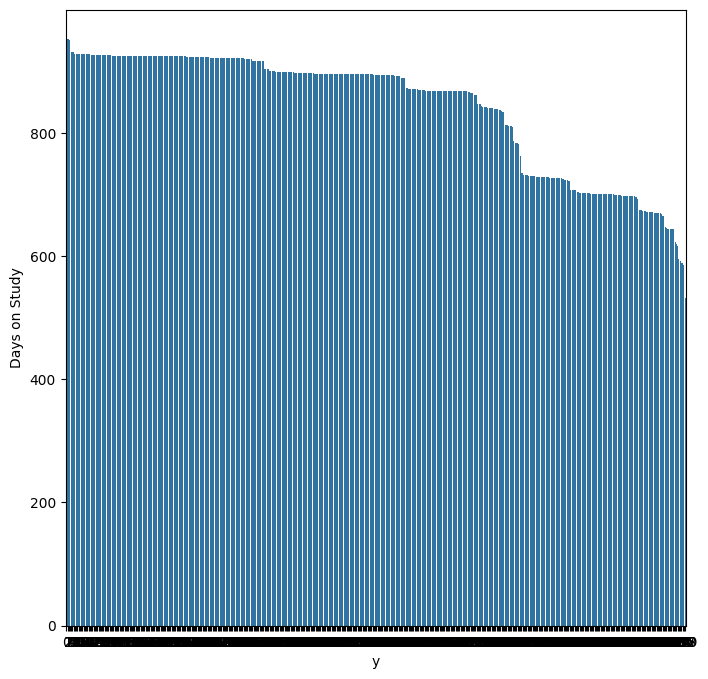

In [78]:
people_data = people_data.sort_values(by='Days on Study', ascending=False) # Sorts the people data by days on study
people_data['y'] = np.arange(500)
fig ,ax = plt.subplots(figsize=(8, 8)) # Creates a figure and axis with a specific size
sns.barplot(data=people_data, y='Days on Study', x='y')

In [80]:
people_data['Average AUC'] = data.groupby('Participant ID')['AUC'].agg(stats.gmean) # Drop duplicate rows for each participant, keeping the last one

In [84]:
sorted_people = people_data[people_data['Infection Pre-Vaccine'] == 'No'].sort_values(by='Average AUC', ascending=False)
highest_performers = sorted_people.head(30).index
lowest_performers = sorted_people.tail(30).index

## Exporting deidentified metadata

Once we pick participants and samples, we want to provide the associated metadata to whoever is running the additional testing.
- What information do they need?
- What information can't they have? (emails, for sure)
- What kinds of testing would you want to do? You'll get back WA.1 SARS-CoV-2 neutralization, for sure, but is there anything else that would help?

Once you have an idea for that, make a subset of the datasheet and export it. To make a csv, you take a dataframe `data` and call `data.to_csv('output_filename.csv')`

In [86]:
data['High Performers'] = data['Participant ID'].isin(highest_performers)
data['Low Performers'] = data['Participant ID'].isin(lowest_performers)
data['Of Interest'] = data['High Performers'] | data['Low Performers']
sample_data_to_send = data[data['Of Interest']]

In [87]:
sample_data_to_send.shape

(1054, 20)

In [92]:
sample_data_to_send['Days from Dose 1'] = (pd.to_datetime(sample_data_to_send['Date']) - pd.to_datetime(sample_data_to_send['Dose 1 Date'])).dt.days
sample_data_to_send.columns

/tmp/ipykernel_38409/1342624596.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data_to_send['Days from Dose 1'] = (pd.to_datetime(sample_data_to_send['Date']) - pd.to_datetime(sample_data_to_send['Dose 1 Date'])).dt.days


Index(['Participant ID', 'Date', 'AUC', 'Name', 'Email', 'Sex', 'Race',
       'Infection Pre-Vaccine', 'Age', 'Vaccine Type', 'Dose 1 Date',
       'Dose 2 Date', 'Infection 1 Date', 'Infection 2 Date', 'Dose 3 Date',
       'Baseline Date', 'Time Between Dose 3 and Dose 2', 'High Performers',
       'Low Performers', 'Of Interest', 'Days from Dose 1'],
      dtype='object')

In [93]:
sample_data_to_send.loc[:, ['Participant ID', 'Days from Dose 1', 'AUC', 'Sex', 'Race',
       'Infection Pre-Vaccine', 'Age', 'Vaccine Type', 'High Performers',
       'Low Performers']]

,Participant ID,Days from Dose 1,AUC,Sex,Race,Infection Pre-Vaccine,Age,Vaccine Type,High Performers,Low Performers
Sample ID,,,,,,,,,,
W4531,SPARTA-006,-15,5.000000,Female,White,No,37,Pfizer,True,False
Y2355,SPARTA-006,10,520.263566,Female,White,No,37,Pfizer,True,False
I9194,SPARTA-006,41,2664.257240,Female,White,No,37,Pfizer,True,False
A6310,SPARTA-006,69,1377.894378,Female,White,No,37,Pfizer,True,False
P4766,SPARTA-006,98,640.044870,Female,White,No,37,Pfizer,True,False
...,...,...,...,...,...,...,...,...,...,...
O1940,SPARTA-491,527,7075.206819,Female,Black or African American,No,50,Pfizer,True,False
J8771,SPARTA-491,559,1980.196722,Female,Black or African American,No,50,Pfizer,True,False
Q1491,SPARTA-491,589,3492.899599,Female,Black or African American,No,50,Pfizer,True,False


In [94]:
sample_data_to_send.loc[:, ['Participant ID', 'Days from Dose 1', 'AUC', 'Sex', 'Race',
       'Infection Pre-Vaccine', 'Age', 'Vaccine Type', 'High Performers',
       'Low Performers']].to_csv('../data/SPARTA_sample_data.csv')